In [21]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST MT 2016
---

## VEST Documentation

### Election Results

#### Sources
Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

#### Sources
Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program. 

The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley.

### Processing
Precinct splits in Lake County were reversed based on the 2016 precinct shapefile from the county. The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [22]:
vest_mt_16 = gp.read_file("./raw-from-source/VEST/mt_2016/mt_2016.shp")

In [23]:
vest_mt_16.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

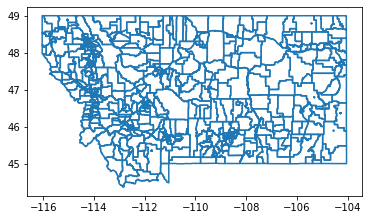

In [24]:
vest_mt_16.boundary.plot()

In [25]:
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for MT

In [26]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
mt_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Created `2016-General-Results-by-Precinct.csv` from `2016-General-Results-by-Precinct.xlsx` by opening in Excel and saving as a csv. No file modifications were made. 

In [27]:
#Load in clean SOS file
elections_2016 = pd.read_csv("./raw-from-source/MT_SOS/2016-General-Results-by-Precinct.csv")

In [28]:
elections_2016.shape

(31197, 21)

In [29]:
elections_2016.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Beaverhead,PRECINCT 01,PRESIDENT AND VICE PRESIDENT,DEM,175,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Beaverhead,PRECINCT 12,PRESIDENT AND VICE PRESIDENT,DEM,157,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beaverhead,PRECINCT 14,PRESIDENT AND VICE PRESIDENT,DEM,125,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Beaverhead,PRECINCT 17,PRESIDENT AND VICE PRESIDENT,DEM,18,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Beaverhead,PRECINCT 19,PRESIDENT AND VICE PRESIDENT,DEM,14,HILLARY CLINTON AND TIM KAINE,72,36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare to Pivot Election Results

In [30]:
#Filter down to the offices we need
office_list = ['PRESIDENT AND VICE PRESIDENT','UNITED STATES REPRESENTATIVE','GOVERNOR & LT. GOVERNOR',
               'ATTORNEY GENERAL','SECRETARY OF STATE','STATE AUDITOR',
               'STATE SUPERINTENDENT OF PUBLIC INSTRUCTION']
elections_2016 = elections_2016[elections_2016["RaceName"].isin(office_list)]

In [31]:
elections_2016["NameOnBallot"].unique()

array(['HILLARY CLINTON AND TIM KAINE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG',
       'GARY JOHNSON AND BILL WELD', 'JILL STEIN AND AJAMU BARAKA',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'RICK BRECKENRIDGE',
       'DENISE JUNEAU', 'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER',
       'GREG GIANFORTE AND LESLEY ROBINSON', 'MONICA J. LINDEEN',
       'ROGER ROOTS', 'COREY STAPLETON', 'TIM FOX', 'LARRY JENT',
       'JESSE LASLOVICH', 'MATT ROSENDALE', 'ELSIE ARNTZEN',
       'MELISSA ROMANO'], dtype=object)

In [32]:
# Change column names to match the county fips dict
elections_2016.loc[elections_2016['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Map to the correct FIP
elections_2016["county"]=elections_2016["CountyName"].map(mt_fips_dict).fillna(elections_2016["CountyName"])

#Print out the FIPS to make sure they all are in the correct format
elections_2016["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [33]:
print(elections_2016["CountyName"].nunique())
print(len(mt_fips_dict))

56
56


In [34]:
#Clean up the precinct column by striping the white space
elections_2016["PrecinctName"]=elections_2016["PrecinctName"].str.strip()

#Create a column to pivot one by concatenating the FIPS with the precinct
elections_2016["pivot_col"]=elections_2016["county"]+elections_2016["PrecinctName"]

### Pivot Election Results

In [35]:
#Run the pivot
pivoted_2016 = pd.pivot_table(elections_2016,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill NA values w/ 0
pivoted_2016 = pivoted_2016.fillna(0)

#Clean the columns
pivoted_2016.reset_index(drop=False,inplace=True)
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)

In [36]:
#Print the df to get a sense for it
pivoted_2016.head()

NameOnBallot,,COREY STAPLETON,DENISE JUNEAU,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,GARY JOHNSON AND BILL WELD,GREG GIANFORTE AND LESLEY ROBINSON,HILLARY CLINTON AND TIM KAINE,JESSE LASLOVICH,JILL STEIN AND AJAMU BARAKA,...,MATT ROSENDALE,MELISSA ROMANO,MONICA J. LINDEEN,RICK BRECKENRIDGE,ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG,ROGER ROOTS,RYAN ZINKE,STEVE BULLOCK AND MIKE COONEY,TED DUNLAP AND RON VANDEVENDER,TIM FOX
0,001PRECINCT 01,229,205,203,196,48,176,175,229,15,...,208,236,193,22,1,23,230,267,15,275
1,001PRECINCT 02,540,178,551,511,35,482,127,244,16,...,476,212,161,27,4,32,546,249,23,600
2,001PRECINCT 03,524,186,507,469,32,470,158,257,5,...,443,236,184,17,0,18,532,252,15,587
3,001PRECINCT 04,123,41,131,121,6,109,34,48,1,...,118,48,41,6,0,2,128,60,4,143
4,001PRECINCT 05,100,16,99,91,4,99,9,21,1,...,92,22,14,2,0,3,100,17,2,105


In [37]:
pivoted_2016.columns

Index(['', 'COREY STAPLETON', 'DENISE JUNEAU',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'ELSIE ARNTZEN',
       'GARY JOHNSON AND BILL WELD', 'GREG GIANFORTE AND LESLEY ROBINSON',
       'HILLARY CLINTON AND TIM KAINE', 'JESSE LASLOVICH',
       'JILL STEIN AND AJAMU BARAKA', 'LARRY JENT', 'MATT ROSENDALE',
       'MELISSA ROMANO', 'MONICA J. LINDEEN', 'RICK BRECKENRIDGE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG', 'ROGER ROOTS',
       'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER', 'TIM FOX'],
      dtype='object', name='NameOnBallot')

In [38]:
#Rename the columns
pivoted_2016.columns = ["join_col",'G16SOSRSTA', 'G16HALDJUN',
       'G16PRERTRU', 'G16SPIRARN',
       'G16PRELJOH', 'G16GOVRGIA',
       'G16PREDCLI', 'G16AUDDLAS',
       'G16PREGSTE', 'G16ATGDJEN', 'G16AUDRROS',
       'G16SPIDROM', 'G16SOSDLIN', 'G16HALLBRE',
       'G16PREOFUE', 'G16SOSLROO',
       'G16HALRZIN', 'G16GOVDBUL',
       'G16GOVLDUN', 'G16ATGRFOX']

In [39]:
#Add in a column with the state, county and precinct name
pivoted_2016["STATEFP10"]="30"
pivoted_2016["COUNTYFP10"]=pivoted_2016["join_col"].str[0:3]
pivoted_2016["NAME"]=pivoted_2016["join_col"].str[3:]

In [40]:
pivoted_2016.head()

,join_col,G16SOSRSTA,G16HALDJUN,G16PRERTRU,G16SPIRARN,G16PRELJOH,G16GOVRGIA,G16PREDCLI,G16AUDDLAS,G16PREGSTE,...,G16HALLBRE,G16PREOFUE,G16SOSLROO,G16HALRZIN,G16GOVDBUL,G16GOVLDUN,G16ATGRFOX,STATEFP10,COUNTYFP10,NAME
0,001PRECINCT 01,229,205,203,196,48,176,175,229,15,...,22,1,23,230,267,15,275,30,001,PRECINCT 01
1,001PRECINCT 02,540,178,551,511,35,482,127,244,16,...,27,4,32,546,249,23,600,30,001,PRECINCT 02
2,001PRECINCT 03,524,186,507,469,32,470,158,257,5,...,17,0,18,532,252,15,587,30,001,PRECINCT 03
3,001PRECINCT 04,123,41,131,121,6,109,34,48,1,...,6,0,2,128,60,4,143,30,001,PRECINCT 04
4,001PRECINCT 05,100,16,99,91,4,99,9,21,1,...,2,0,3,100,17,2,105,30,001,PRECINCT 05


In [41]:
#Take a look at VEST's file
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

In [42]:
#Reorder the election result df's columns to match VEST's
pivoted_2016 = pivoted_2016[['STATEFP10', 'COUNTYFP10', 'NAME','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM',"join_col"]]

#Create a join column in the VEST file
vest_mt_16["join_col"]=vest_mt_16['COUNTYFP10']+vest_mt_16['NAME']

In [43]:
pivoted_2016.shape

(686, 24)

## Compare Election Results Totals

### Compare Total Votes

In [44]:
races = [x for x in vest_mt_16.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PREOFUE',
 'G16HALRZIN',
 'G16HALDJUN',
 'G16HALLBRE',
 'G16GOVRGIA',
 'G16GOVDBUL',
 'G16GOVLDUN',
 'G16ATGRFOX',
 'G16ATGDJEN',
 'G16SOSRSTA',
 'G16SOSDLIN',
 'G16SOSLROO',
 'G16AUDRROS',
 'G16AUDDLAS',
 'G16SPIRARN',
 'G16SPIDROM']

In [45]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_16[i])
    sum_var_2 += np.sum(pivoted_2016[i])
print(sum_var_1)
print(sum_var_2)

3481824
3481824


### Compare Race Totals

In [46]:
for race in races:
    diff_val = sum(vest_mt_16[race])-sum(pivoted_2016[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G16PRERTRU: EQUAL
G16PREDCLI: EQUAL
G16PRELJOH: EQUAL
G16PREGSTE: EQUAL
G16PREOFUE: EQUAL
G16HALRZIN: EQUAL
G16HALDJUN: EQUAL
G16HALLBRE: EQUAL
G16GOVRGIA: EQUAL
G16GOVDBUL: EQUAL
G16GOVLDUN: EQUAL
G16ATGRFOX: EQUAL
G16ATGDJEN: EQUAL
G16SOSRSTA: EQUAL
G16SOSDLIN: EQUAL
G16SOSLROO: EQUAL
G16AUDRROS: EQUAL
G16AUDDLAS: EQUAL
G16SPIRARN: EQUAL
G16SPIDROM: EQUAL


### Compare County Totals

In [47]:
diff_counties=[]
for i in races:
    diff = pivoted_2016.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_16.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(race, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(race + ' county totals: EQUAL')

G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL
G16SPIDROM county totals: EQUAL


### Check for Zero Vote Precincts in VEST

In [48]:
vest_mt_16[vest_mt_16['G16PRERTRU'] == 0]

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOFUE,...,G16ATGDJEN,G16SOSRSTA,G16SOSDLIN,G16SOSLROO,G16AUDRROS,G16AUDDLAS,G16SPIRARN,G16SPIDROM,geometry,join_col
389,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79807 48.22350, -113.79620 48.2...",029NA
390,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79240 48.38270, -113.79256 48.3...",029NA
682,30,047,Lake,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-114.03396 47.95345, -114.03355 47.9...",047NA


### Attempt to join the dataframes

In [49]:
join_attempt_one = pd.merge(vest_mt_16,pivoted_2016,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

left_only     597
right_only    594
both           92
Name: _merge, dtype: int64


In [50]:
join_attempt_one.columns

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY', 'NAME_x', 'SOSPRECINC',
       'G16PRERTRU_x', 'G16PREDCLI_x', 'G16PRELJOH_x', 'G16PREGSTE_x',
       'G16PREOFUE_x', 'G16HALRZIN_x', 'G16HALDJUN_x', 'G16HALLBRE_x',
       'G16GOVRGIA_x', 'G16GOVDBUL_x', 'G16GOVLDUN_x', 'G16ATGRFOX_x',
       'G16ATGDJEN_x', 'G16SOSRSTA_x', 'G16SOSDLIN_x', 'G16SOSLROO_x',
       'G16AUDRROS_x', 'G16AUDDLAS_x', 'G16SPIRARN_x', 'G16SPIDROM_x',
       'geometry', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'NAME_y',
       'G16PRERTRU_y', 'G16PREDCLI_y', 'G16PRELJOH_y', 'G16PREGSTE_y',
       'G16PREOFUE_y', 'G16HALRZIN_y', 'G16HALDJUN_y', 'G16HALLBRE_y',
       'G16GOVRGIA_y', 'G16GOVDBUL_y', 'G16GOVLDUN_y', 'G16ATGRFOX_y',
       'G16ATGDJEN_y', 'G16SOSRSTA_y', 'G16SOSDLIN_y', 'G16SOSLROO_y',
       'G16AUDRROS_y', 'G16AUDDLAS_y', 'G16SPIRARN_y', 'G16SPIDROM_y',
       '_merge'],
      dtype='object')

In [51]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTY','NAME_x','SOSPRECINC','NAME_y','join_col']]

,COUNTY,NAME_x,SOSPRECINC,NAME_y,join_col
0,Missoula,Bonner 89,BONNER 89,NaN,063Bonner 89
1,Missoula,Bonner 92,BONNER 92,NaN,063Bonner 92
2,Missoula,C S Porter 98,CSPORTER 98,NaN,063C S Porter 98
3,Missoula,Chief Charlo 90,CHIEF CHARLO 90,NaN,063Chief Charlo 90
4,Missoula,Clinton 89,CLINTON 89,NaN,063Clinton 89
...,...,...,...,...,...
1278,NaN,NaN,NaN,PRECINCT 2,107PRECINCT 2
1279,NaN,NaN,NaN,PRECINCT 3,107PRECINCT 3
1280,NaN,NaN,NaN,PRECINCT 4,107PRECINCT 4
1281,NaN,NaN,NaN,PRECINCT 9,107PRECINCT 9


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the 2020 TIGER/Line files for MT, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/30_MONTANA/30/

In [32]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_30_vtd20/tl_2020_30_vtd20.shp')

In [33]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,30,049,000027,30049000027,A,PCT 27,PCT 27,00,G5240,N,29808693,741,+46.7492670,-112.0442420,"POLYGON ((-112.08980 46.78522, -112.05939 46.7..."


In [34]:
tiger_vtd.shape

(666, 15)

<AxesSubplot:>

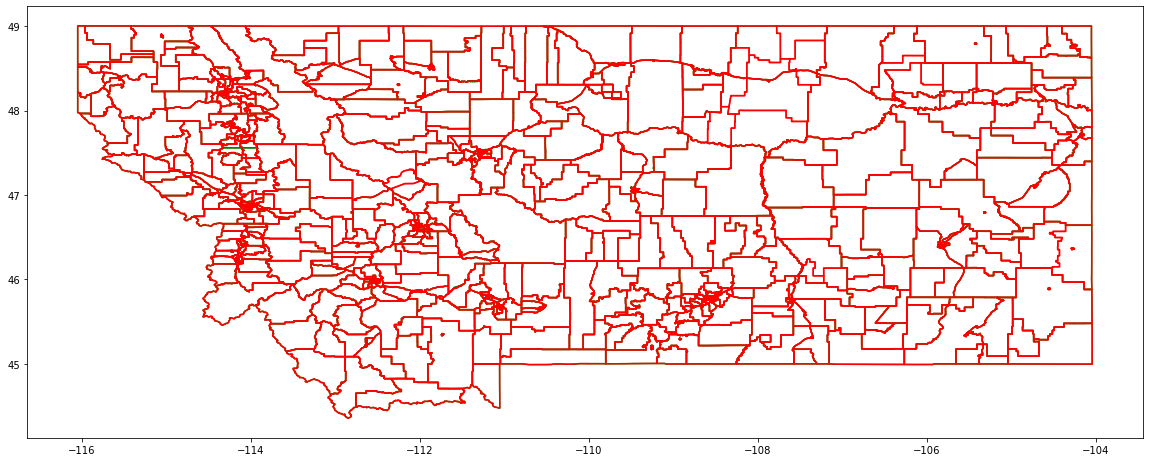

In [35]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_mt_16.boundary.plot(figsize=(20,20),ax=ax,color="red")

With a cursory look, this looks correct. 

### Shp from SOS

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the shapefile from the SOS: https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7bdbd29997-21d8-4af1-9d87-5c5134775995%7d
Navigate to "Download Data", select "MontanaVotingPrecincts_shp.zip". 

Confirming whether this file is the same as the TIGER/Line file. 

In [36]:
mt_shp = gp.read_file('./raw-from-source/SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [37]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [38]:
mt_shp.shape

(666, 17)

In [39]:
mt_shp.crs

{'init': 'epsg:32100'}

In [40]:
vest_mt_16 = vest_mt_16.to_crs(epsg=32100)

<AxesSubplot:>

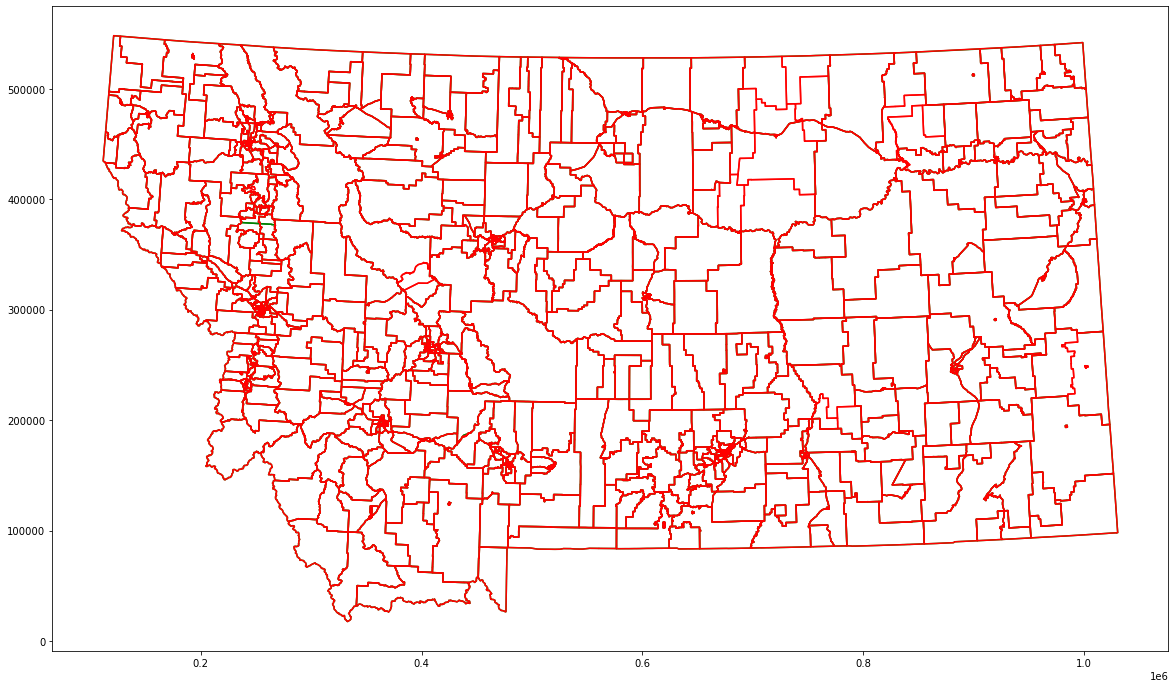

In [41]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_16.boundary.plot(figsize=(20,20),ax=ax,color="red")

Ultimately, the TIGER/Line and the file directly from the SOS look the same, though the columns in them differ slightly. 

Leaving it to the person assigned to this state to determine which file to use, that will make joining to the election results and replicating VEST's file easier. 

### County Specific Shapefiles

> The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley.

At the time of this writing, we do not have access to any of the county specific maps. 

> The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

Found these maps here that are PDFs but we can use to compare: 
https://www.lccountymt.gov/it/gis-maps/completed-maps/voting-precincts.html. No shapefiles available. 